In [2]:
import os
import math
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class TypeEncoding(nn.Module):
    def __init__(self, d_model, num_types=2):
        super(TypeEncoding, self).__init__()
        self.embedding = nn.Embedding(num_types, d_model)

    def forward(self, x, type_ids):
        return x + self.embedding(type_ids)

class CrossModalTransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1):
        super(CrossModalTransformerEncoder, self).__init__()
        self.d_model = d_model
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

    def forward(self, src, src_mask=None):
        output = self.transformer_encoder(src, src_mask)
        return output

class CrossModalTransformerModel(nn.Module):
    def __init__(self, audio_dim, text_dim, d_model, nhead, num_layers, dim_feedforward, dropout, max_len=10000, num_types=2):
        super(CrossModalTransformerModel, self).__init__()

        self.audio_dim = audio_dim
        self.text_dim = text_dim
        self.d_model = d_model

        # 1. 维度转换层
        self.audio_linear = nn.Linear(audio_dim, d_model)
        self.text_linear = nn.Linear(text_dim, d_model)

        # 2. Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # 3. Type Encoding
        self.type_encoding = TypeEncoding(d_model, num_types)

        # 4. Cross-Modal Transformer Encoder
        self.cross_modal_encoder = CrossModalTransformerEncoder(d_model, nhead, num_layers, dim_feedforward, dropout)

        # 5. 分类头 (这里简化为一个线性层 + sigmoid)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 1),
            nn.Sigmoid()
        )

    def forward(self, audio_embeddings, text_embeddings):
        # 1. 准备输入序列
        audio_embeddings = self.audio_linear(audio_embeddings) # (batch_size, audio_seq_len, audio_dim) -> (batch_size, audio_seq_len, d_model)
        text_embeddings = self.text_linear(text_embeddings)   # (batch_size, text_seq_len, text_dim) -> (batch_size, text_seq_len, d_model)

        batch_size, audio_seq_len, _ = audio_embeddings.shape
        _, text_seq_len, _ = text_embeddings.shape

        cls_a = torch.zeros(batch_size, 1, self.d_model, device=audio_embeddings.device)  # [CLS_A] token
        cls_t = torch.zeros(batch_size, 1, self.d_model, device=audio_embeddings.device)  # [CLS_T] token
        sep = torch.zeros(batch_size, 1, self.d_model, device=audio_embeddings.device)    # [SEP] token

        combined_embeddings = torch.cat([cls_a, audio_embeddings, sep, cls_t, text_embeddings], dim=1) # 拼接

        # 3. 添加位置编码和类型编码
        type_ids = torch.cat([
            torch.zeros(batch_size, audio_seq_len + 2, dtype=torch.long, device=audio_embeddings.device), # 0 for audio, [CLS_A], [SEP]
            torch.ones(batch_size, text_seq_len + 1, dtype=torch.long, device=audio_embeddings.device)   # 1 for text, [CLS_T]
        ], dim=1)
        combined_embeddings = self.positional_encoding(combined_embeddings * math.sqrt(self.d_model)) # 通常需要对embedding进行scale
        combined_embeddings = self.type_encoding(combined_embeddings, type_ids)

        # 4. Cross-Modal Transformer Encoder
        encoded_embeddings = self.cross_modal_encoder(combined_embeddings)

        # 5. 分类 (这里取 [CLS_A] token 的输出, 你也可以尝试其他方式)
        cls_a_output = encoded_embeddings[:, 0, :]
        cls_t_output = encoded_embeddings[:, audio_seq_len + 2, :]
        cls_output = cls_a_output + cls_t_output # 可以将cls_a 和 cls_t的输出相加, 或者拼接
        output = self.classifier(cls_output)

        return output

class TextModalTransformerModel(nn.Module):
    def __init__(self, text_dim: int, d_model: int, nhead: int, num_layers: int, dim_feedforward: int, dropout: float, max_len: int=10000, output_method: str = 'cls', num_types: int=2):
        super(TextModalTransformerModel, self).__init__()

        self.text_dim = text_dim
        self.d_model = d_model
        self.output_method = output_method

        # 1. 维度转换层
        self.text_linear = nn.Linear(text_dim, d_model)

        # 2. Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len)

        # 4. Cross-Modal Transformer Encoder
        self.transformer_encoder = CrossModalTransformerEncoder(d_model, nhead, num_layers, dim_feedforward, dropout)

        self.average_pooling = nn.AdaptiveAvgPool1d(1)
        # 5. 分类头 (这里简化为一个线性层 + sigmoid)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 1),
            nn.Sigmoid()
        )

    def forward(self, text_embeddings):
        embedding = self.text_linear(text_embeddings)   # (batch_size, text_seq_len, text_dim) -> (batch_size, text_seq_len, d_model)
        batch_size, seq_len, _ = embedding.shape

        match self.output_method:
            case 'cls':
                cls_t = torch.zeros(batch_size, 1, self.d_model, device=embedding.device)  # [CLS_T] token
                embedding = torch.cat([cls_t, embedding], dim=1)
            case 'avg_pool':
                pass
            case _:
                pass

        embedding = self.positional_encoding(embedding * math.sqrt(self.d_model)) # 通常需要对embedding进行scale
        embedding = self.transformer_encoder(embedding)

        match self.output_method:
            case 'cls':
                output = embedding[:, 0, :]
            case 'avg_pool':
                output = self.average_pooling(embedding.transpose(1, 2)).squeeze(2)
            case _:
                output = None

        output = self.classifier(output)
        return output

In [4]:
class StoriesDataset(Dataset):
    def __init__(self, dataset_df: pd.DataFrame, text_path: Path, vocal_path: Path):
        self.df = dataset_df
        self.text_path = text_path
        self.vocal_path = vocal_path

    def __getitem__(self, idx):
        if idx >= len(self):
            return None
        filename_stem = ".".join(self.df.loc[idx, 'filename'].split(".")[:-1])
        vocal_embedded_path = self.vocal_path.joinpath(filename_stem + ".npy")
        text_embedded_path = self.text_path.joinpath(filename_stem + ".npz")
        # (bs, seq_len, dim)
        vocal_embedded = np.load(vocal_embedded_path)
        text_embedded = np.load(text_embedded_path)["embedding"][0, :, :]
        vocal_embedded = np.transpose(vocal_embedded, (0, 2, 1))[0, :, :]
        label = np.asarray([[1 if self.df.loc[idx, 'label'] else 0]], dtype=np.float32)
        return { "text": text_embedded, "vocal": vocal_embedded, "label": label }

    def __len__(self):
        return len(self.df)


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, device, dataset_df: pd.DataFrame, text_path: Path, vocal_path: Path, ckpt_path: Path | None, val_percent: float = 0.1, amp=False, epochs=10, learning_rate=1e-4, batch_size=1, modal_type: str = "MultiModal", model_out_method: str = "cls"):
    # ret vals definitions
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    cplt_epoches = 0

    dataset = StoriesDataset(dataset_df, text_path, vocal_path)
    # print(dataset.__getitem__(1))

    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    loader_args = dict(batch_size=batch_size, num_workers=0, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    match modal_type:
        case "MultiModal":
            model_summary = summary(model, input_size=[(1, 10240, 512), (1, 512, 1536)])
        case "TextModal":
            model_summary = summary(model, input_size=(1, 512, 1536))
        case _:
            raise NotImplementedError
    model_params = model_summary.to_megabytes(model_summary.total_input + model_summary.total_output_bytes + model_summary.total_param_bytes)

    print(f'''Starting training:
        Epochs:          {epochs}
        Model size:      {model_params} MBytes
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {ckpt_path.absolute()}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    def infer(infer_model, audio_inputs, text_inputs):
        match modal_type:
            case "MultiModal":
                return infer_model(audio_inputs, text_inputs)
            case "TextModal":
                return infer_model(text_inputs)
            case "AudioModal":
                return infer_model(audio_inputs)
        return None

    try:
        for epoch in range(1, epochs+1):
            model.train()
            epoch_loss = 0.0
            with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}') as pbar:
                for batch in train_loader:
                    audio_embedded = batch["vocal"].to(device)
                    text_embedded = batch["text"].to(device)
                    labels = batch["label"].to(device)

                    # 前向传播
                    outputs = infer(model, audio_embedded, text_embedded)
                    # print(f"output: {outputs.squeeze()}\t label: {labels}")
                    loss = criterion(outputs.squeeze(), labels.squeeze().float())

                    # 反向传播和优化
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    pbar.update(batch_size)
                    epoch_loss += loss.item()
                    pbar.set_postfix(**{'loss (batch)': loss.item()})

                epoch_loss /= len(train_loader)
                # print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.3f}")

            # train acc
            model.eval()
            train_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in train_loader:
                    audio_embedded = batch["vocal"].to(device)
                    text_embedded = batch["text"].to(device)
                    labels = batch["label"].to(device)  # 假设标签在数据集中

                    outputs = infer(model, audio_embedded, text_embedded)
                    loss = criterion(outputs.squeeze(), labels.squeeze().float())
                    train_loss += loss.item()

                    predicted = (outputs > 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            train_epoch_loss = train_loss / len(train_loader)
            train_accuracy = correct / total
            print(f"[Train] Loss: {train_epoch_loss:.4f}, Acc: {train_accuracy:.4f}", end="\t")

            # 验证
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            # temp = []
            with torch.no_grad():
                for batch in val_loader:
                    audio_embedded = batch["vocal"].to(device)
                    text_embedded = batch["text"].to(device)
                    labels = batch["label"].to(device)  # 假设标签在数据集中

                    outputs = infer(model, audio_embedded, text_embedded)
                    loss = criterion(outputs.squeeze(), labels.squeeze().float())
                    val_loss += loss.item()

                    predicted = (outputs > 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    # temp.append((outputs, labels))

            val_epoch_loss = val_loss / len(val_loader)
            val_accuracy = correct / total
            print(f"[Validation] Loss: {val_epoch_loss:.4f}, Acc: {val_accuracy:.4f}", end="\t")
            # print(temp)

            if ckpt_path and epoch % 5 == 0:
                ckpt_path.mkdir(parents=True, exist_ok=True)
                state_dict = model.state_dict()
                # state_dict['mask_values'] = dataset.mask_values
                torch.save(state_dict, os.path.join(ckpt_path, f'{modal_type}-acc={val_accuracy:.3f}-e{epoch}-{model_out_method}-{datetime.now().strftime("%Y%m%d_%H_%M_%S")}.pth'))
                print(f'Checkpoint {epoch} saved!')
            else:
                print()

            train_accs.append(train_accuracy)
            train_losses.append(train_epoch_loss)
            val_accs.append(val_accuracy)
            val_losses.append(val_epoch_loss)
            cplt_epoches = epoch

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        if ckpt_path:
            print("Saving last checkpoint...")
            ckpt_path.mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            # state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, os.path.join(ckpt_path, f'{modal_type}-AUTOSAVE-e{cplt_epoches[-1]}-{model_out_method}-{datetime.now().strftime("%Y%m%d_%H_%M_%S")}.pth'))
            print(f'Checkpoint {epoch} saved!')
    finally:
        return train_losses, train_accs, val_losses, val_accs, cplt_epoches

# 示例数据集路径
CKPT_PATH = Path("./ckpt")

DATASET_VOCAL_EMBED = Path("../datasets/vocal_embedded")
DATASET_TEXT_EMBED  = Path("../datasets/text_embedded")
DATASET_ATTR_CSV    = Path("../datasets/dataset_attr.csv")
dataset_attr_df     = pd.read_csv(DATASET_ATTR_CSV)

audio_dim = 512
text_dim = 1536

# Text-modal
# d_model = 512
# nhead = 16
# num_layers = 12
# dim_feedforward = 8192
# dropout = 0.1
# model_out_method = "cls"
# modal_type = "TextModal"
# text_model = TextModalTransformerModel(text_dim, d_model=text_dim, nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward, output_method=model_out_method, dropout=0.1)
# train_loss, train_acc, val_loss, val_acc, epoches \
#     = train_model(
#         text_model,
#         DEVICE,
#         dataset_df  = dataset_attr_df,
#         text_path   = DATASET_TEXT_EMBED,
#         vocal_path  = DATASET_VOCAL_EMBED,
#         ckpt_path   = CKPT_PATH,
#         amp =   False,
#         val_percent     = 0.1,
#         learning_rate   = 1e-7,
#         epochs          = 100,
#         batch_size      = 1,
#         modal_type      = "TextModal",
#         model_out_method = "cls"
#     )

# Multi-modal
d_model = 512
nhead = 8
num_layers = 6
dim_feedforward = 3072
dropout = 0.1
model_out_method = "cls"
modal_type = "MultiModal"
model = CrossModalTransformerModel(audio_dim, text_dim, d_model, nhead, num_layers, dim_feedforward, dropout).to(DEVICE)
train_loss, train_acc, val_loss, val_acc, epoches \
    = train_model(
        model,
        DEVICE,
        dataset_df  = dataset_attr_df,
        text_path   = DATASET_TEXT_EMBED,
        vocal_path  = DATASET_VOCAL_EMBED,
        ckpt_path   = CKPT_PATH,
        amp =  False,
        val_percent     = 0.1,
        learning_rate   = 3e-6,
        epochs          = 100,
        batch_size      = 1,
        modal_type      = modal_type,
        model_out_method = model_out_method,
    )


In [34]:
# inference
def infer(model, audio_embedded, text_embedded, modal_type):
    def _infer(infer_model, audio_inputs, text_inputs):
        match modal_type:
            case "MultiModal":
                return infer_model(audio_inputs, text_inputs)
            case "TextModal":
                return infer_model(text_inputs)
            case "AudioModal":
                return infer_model(audio_inputs)
        return None
    model.eval()
    with torch.no_grad():
        return _infer(model, audio_embedded, text_embedded)

dataset = StoriesDataset(dataset_attr_df, DATASET_TEXT_EMBED, DATASET_VOCAL_EMBED)

rand_idx = np.random.randint(0, len(dataset)-1, 1).item()
item = dataset.__getitem__(rand_idx)

audio_embedded = torch.from_numpy(item["vocal"][np.newaxis,:]).to(DEVICE)
text_embedded = torch.from_numpy(item["text"][np.newaxis,:]).to(DEVICE)
result = infer(model, audio_embedded, text_embedded, modal_type)
result = result.to(torch.device("cpu")).numpy().item()

filename = dataset_attr_df.loc[rand_idx, "filename"]
result = "True Story" if result > 0.5 else "Deceptive Story"
true_result = dataset_attr_df.loc[rand_idx, "Story_type"]
print(f"[{filename}]\n\tinfer result: {result}\n\t true result: {true_result}")

[00085.wav]
	infer result: Deceptive Story
	 true result: Deceptive Story


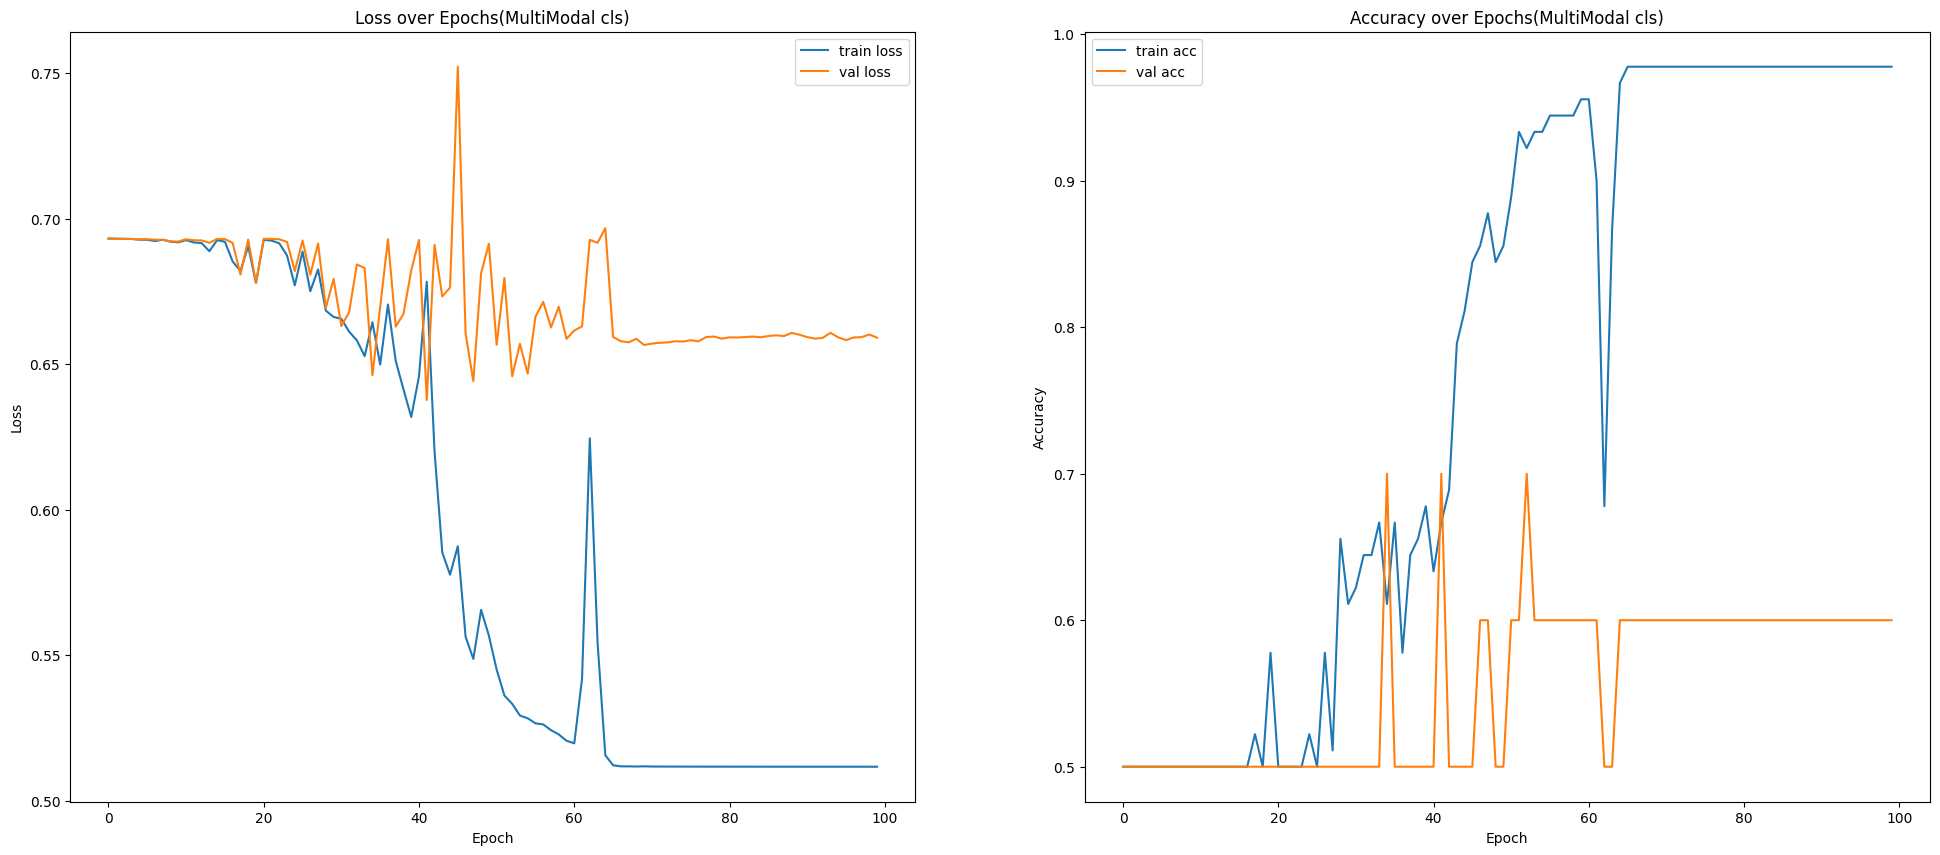

In [14]:
import matplotlib.pyplot as plot

plot.figure(figsize=(24, 10))
ax = plot.subplot(1, 2, 1)
ax.plot(train_loss, label="train loss")
ax.plot(val_loss, label="val loss")
ax.set_title(f"Loss over Epochs({modal_type} {model_out_method})")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax = plot.subplot(1, 2, 2)
ax.plot(train_acc, label="train acc")
ax.plot(val_acc, label="val acc")
ax.set_title(f"Accuracy over Epochs({modal_type} {model_out_method})")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
plot.savefig(Path(f"./results/{modal_type}-{model_out_method}-{datetime.now().strftime("%Y%m%d_%H_%M_%S")}.png"), bbox_inches='tight')
plot.show()
